In [53]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Oct 18

@author: yaning
"""

import HH_original as HH
import numpy as np
import matplotlib.pyplot as plt

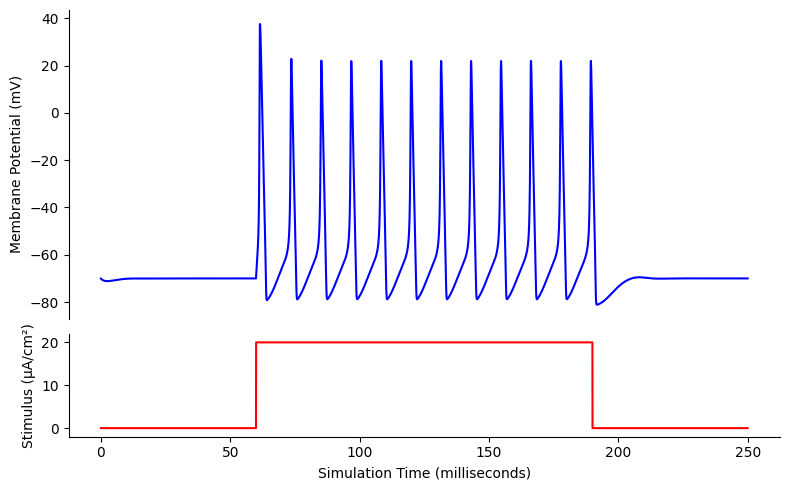

In [2]:
hh = HH.HHModel()
pointCount = 5000
voltages = np.empty(pointCount)
times = np.arange(pointCount) * 0.05
stim = np.zeros(pointCount)
stim[1200:3800] = 20  # create a square pulse

for i in range(len(times)):
    hh.Iterate(stimulusCurrent=stim[i], deltaTms=0.05)
    voltages[i] = hh.Vm
    # note: you could also plot hh's n, m, and k (channel open states)

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 5),
                                gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(times, voltages - 70, 'b')
ax1.set_ylabel("Membrane Potential (mV)")
# ax1.set_title("Hodgkin-Huxley Spiking Neuron Model", fontSize=16)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(bottom=False)

ax2.plot(times, stim, 'r')
ax2.set_ylabel("Stimulus (µA/cm²)")
ax2.set_xlabel("Simulation Time (milliseconds)")
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.margins(0, 0.1)
plt.tight_layout()
# plt.savefig("dev/concept4.png")
plt.show()